In [67]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
%matplotlib inline

In [80]:
reconstruction = np.load("./10_reconstruction.npy")
features = np.load("./10_features.npy")

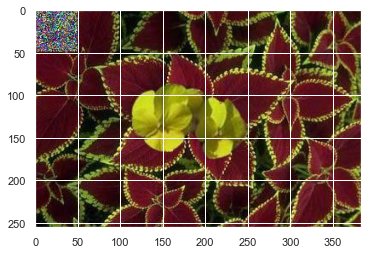

In [81]:
plt.imshow(features)

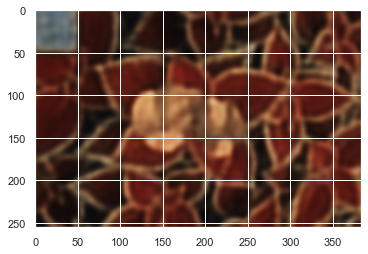

In [82]:
plt.imshow(reconstruction)

<AxesSubplot:>

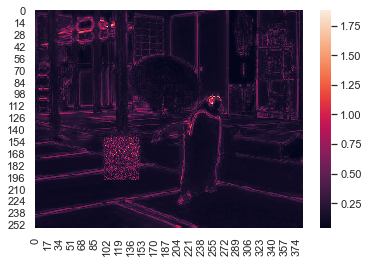

In [85]:
error = np.load("./11_error.npy")
sns.heatmap(error)